# Example 3: Search engines and PSM filtering

In this example we are going to parse the output of several search engines and see what we can do with it using **pyteomics**. We are going to need several major dependencies of **pyteomics**: **lxml**, **numpy**, **matplotlib** and **pandas**.

The files used in this example can be downloaded from http://pubdata.theorchromo.ru/pyteomics_filtering_example/. The directory contains output files from several search engines: X!Tandem, MS Amanda, Morpheus, MS-GF+. All search engines were fed the same spectra. The results do not serve for performance comparison of these search engines, but for illustration of data handling with **pyteomics**.

The data set was kindly provided by Simion Kreimer at Northeastern University in Boston.

Let's start with setting up the imports:

In [1]:
import pylab
from pyteomics import tandem, pepxml, mzid, auxiliary as aux, pylab_aux as pa
import pandas as pd
import numpy as np

Now, let's read an X!Tandem file using `tandem.read()` and build a histogram of retention times for identified spectra. Then, let's do the same for spectra passing the 1% FDR threshold, by using `tandem.filter()`.

In [2]:
# switch to directory with data
%cd example3
pylab.style.use('seaborn-darkgrid')

/home/user/pyteomics_examples/example3


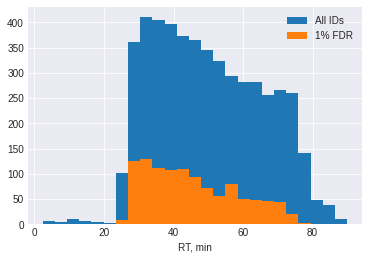

In [3]:
with tandem.read('example.t.xml') as tf:
    h = pylab.hist([psm['rt'] / 60 for psm in tf], bins=25, label='All IDs')
with tandem.filter('example.t.xml', fdr=0.01, full_output=False) as ftf:
    pylab.hist([psm['rt'] / 60 for psm in ftf], bins=h[1], label='1% FDR')
pylab.xlabel('RT, min')
pylab.legend()

The `filter()` functions can be used in the same way as `read()` functions (as a context manager). That is done by specifying `full_output=False`. The benefit of this is lower memory usage when parsing XML files. The downside, however, is that parsing occurs twice, affecting the execution time. That's why the default behavior of `filter()` is simply to return an array of PSMs:

In [4]:
%%time
ftf = tandem.filter('example.t.xml', fdr=0.01)
rts = [psm['rt'] / 60 for psm in ftf]

CPU times: user 13.1 s, sys: 185 ms, total: 13.3 s
Wall time: 13.3 s


In [5]:
%%time
with tandem.filter('example.t.xml', fdr=0.01, full_output=False) as ftf:
   rts = [psm['rt'] / 60 for psm in ftf]

CPU times: user 19 s, sys: 46.6 ms, total: 19 s
Wall time: 19.1 s


Another way would be to build a `pandas.DataFrame` object and access its columns. This enables you to write concise and efficient code. The `tandem` and `pepxml` modules define the functions `DataFrame()` and `filter_df()`, analogous to `read()` and `filter()`.

In [6]:
%%time
ftf = tandem.filter_df('example.t.xml', fdr=0.01)
rts = ftf['rt']

CPU times: user 13 s, sys: 42.8 ms, total: 13 s
Wall time: 13.1 s


A function closely related to `filter()`, `qvalues()`, calculates q-values for all PSMs in a set. `filter()` uses it internally to determine where to set the threshold.

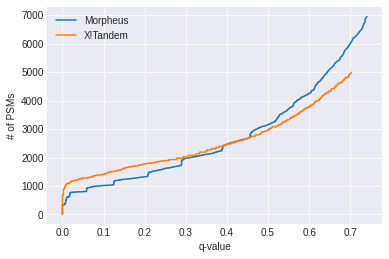

In [7]:
q1 = pepxml.qvalues('example.pep.xml', read_schema=False,
                    key=lambda x: x['search_hit'][0]['search_score']['Morpheus Score'], reverse=True)
q2 = tandem.qvalues('example.t.xml')

pa.plot_qvalue_curve(q1['q'], label='Morpheus')
pa.plot_qvalue_curve(q2['q'], label='X!Tandem')
pylab.legend()

The `mzid` module also provides `qvalues()` and `filter()` functions.

Text(0.5, 0, 'charge state')

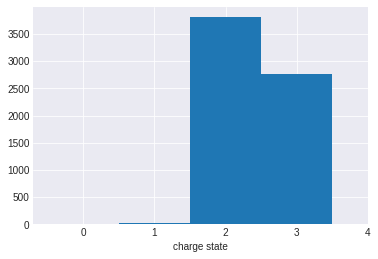

In [8]:
msgf = mzid.filter('example.mzid', retrieve_refs=True,
                   key=lambda x: x['SpectrumIdentificationItem'][0]['MS-GF:EValue'], fdr=0.01)
pylab.hist([psm['SpectrumIdentificationItem'][0]['chargeState'] for psm in msgf], bins=np.arange(5), align='left')
pylab.xticks(np.linspace(0, 4, 5))
pylab.xlabel('charge state')

`pyteomics.auxiliary` provides generic functions `qvalues()` and `filter()` that you can use on any objects representing PSMs. They accept iterables of PSMs (lists, iterators, arrays, DataFrames).

The q-values are calculated using standard target-decoy approach or using posterior error probabilities, if they are provided. With TDA, you need to provide a way to determine the score of a PSM, and whether it is decoy or not. You can do that by passing a function or an array of values. With structured arrays and DataFrames, however, you can simply provide a column / field label. Let's see how easy it is to use `filter()` on the output of Morpheus and MS Amanda using `pandas`.

In [9]:
# read the files into DataFrames
morpheus = pd.read_table('example.PSMs.tsv')
amanda = pd.read_table('example_output.csv', skiprows=1)

In [10]:
# filter the Morpheus DataFrame
morph_filt = aux.filter(morpheus, fdr=0.01, key='Morpheus Score', reverse=True, is_decoy='Decoy?')

<AxesSubplot:xlabel='Retention Time (minutes)', ylabel='Precursor Mass (Da)'>

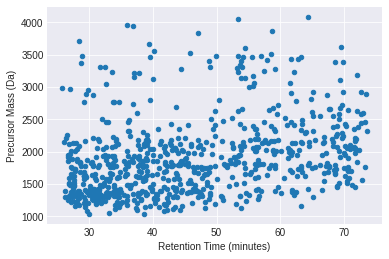

In [11]:
# do some analysis
morph_filt.plot(x='Retention Time (minutes)', y='Precursor Mass (Da)', kind='scatter')

In [12]:
# MS Amanda files don't have a "decoy" column, so let's create one and then use it
amanda['isDecoy'] = amanda['Protein Accessions'].str.split(';').apply(
    lambda x: all(p.startswith('DECOY') for p in x))
amanda_filt = aux.filter(amanda[amanda['Rank'] == 1], key='Weighted Probability', is_decoy='isDecoy', fdr=0.01)

Wasn't that easy? It is also efficient, because we don't need to parse XML, and the calculations are vectorized by `pandas`.

Now we have our filtered DataFrames. We can do something using the awesome `pandas` functionality. For example, let's convert these filtered PSM lists to peptide lists.

In [13]:
amanda_pep = amanda_filt.sort_values('Weighted Probability').groupby('Sequence').first()
morph_pep = morph_filt.sort_values('Q-Value (%)').groupby('Base Peptide Sequence').first()

That's it! Now, why don't we look at peptides present in both lists? Peace of cake for `pandas`, too:

In [14]:
inter = amanda_pep.join(morph_pep, how='inner', lsuffix='[amanda]', rsuffix='[morpheus]')

`inter` is now a DataFrame with all information from both tables (and that's a lot).

<AxesSubplot:xlabel='Amanda Score', ylabel='Morpheus Score'>

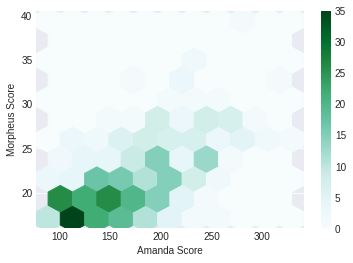

In [15]:
inter.plot('Amanda Score', 'Morpheus Score', kind='hexbin', gridsize=10, sharex=False)

We will conclude this example with a reminder that if you have a piece of software that reports posterior error probabilities (PEPs), `qvalues()` and `filter()` can use them instead of relying on TDA. The usage is similar: you just provide a `pep` parameter instead of `is_decoy`. `key` is not needed in this case, too. Complete information about possible parameters can be found in the API docs.